# 動画処理・動画解析

## パーティクルフィルター
- 乱数を用いた状態推定法

1. パーティクルをばらまく
    - 乱数を使って、n個のパーティクルをばらまく
    - パーティクルを使用して次にどこに行くのかを推定する

2. パーティクルの尤度を計算
    - 真の曲線 = 推定したい対象　-> に近いパーティクルが優秀、そうでないものは優秀ではないパーティクル

- <u>優秀さ加減を計算する公式</u>
    - ガウス分布を使用して尤度の計算を行う
    - 粒子 i の尤度 = X
$$
X=e-\frac{(f(t)-y(i))^2}{2\sigma^2}
$$

3.　リサンプリング（尤度に応じて選ぶ）
- 乱数で n個の粒子を選び直す。尤度が高い粒子ほど選ばれやすい
    - パーティクルが消滅しないように、尤度によって重みづけをして阿弥陀籤をもう一回する
    - その際に重みづけがされているところが選ばれやすい
    - 真の状態に近い所だけが優先的に選ばれて、大きく外れたところはもう一回外れる

4. パーティクルの状態を更新
    - パーティクルの座標をランダムウォークさせる
    - 　パーティクルを少し色々なランダムな方向にばらまく
    - そうする事により次の状態、真の状態の１つ手前から少し離れたところにあるはず
    - <u>真の状態からばら撒くことによって次の状態を予測する</u>

## 尤度(ゆうど)とは？
#### 起きた事象の「 もっともらしさ 」

- コインゲームで考える
    - コインの面が出る確率？
    - 普通であれば 1/2 の確率(50%) だと思うはず

- 7回コインを投げて確かめてみる
    - X = 　表・表・表・裏・表・表・表 -> 7回中　１回しか裏が出てこなかった

#### 7回中表が6回も出た。こんなことがあっていいのか？ = <u>尤度の発想</u>

- 通常だとコインがイカサマではないか？ -> コインの表が出る確率を p としてみる
- 上記の　X の結果を尤度で考えてみる

$$
X=p^6(1-p)^1
$$

- p = 0.5 の尤度はかなり低い -> 多分このコインはイカサマ

#### 尤度は起きた結果（確率・変数）に対して、その結果をグラフに plot して  
#### その現象がどれくらい起こりうるのか？を調べる　＝　<u>尤度</u>

## パーティクルフィルターの実装
- OpenCV には実装されていないので、今回は自力で coding をする

<u>動く電車に追従するようにパーティクルフィルターを実装していく</u>

#### Tram video image particle前

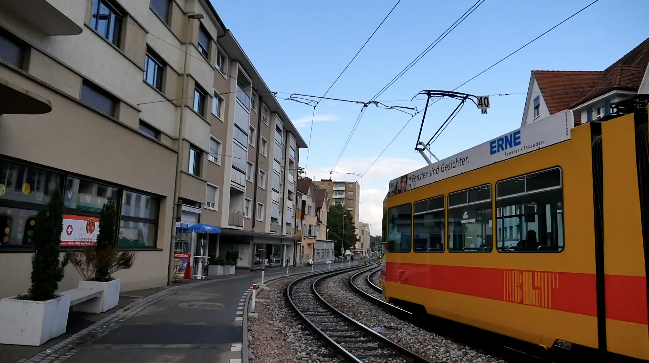

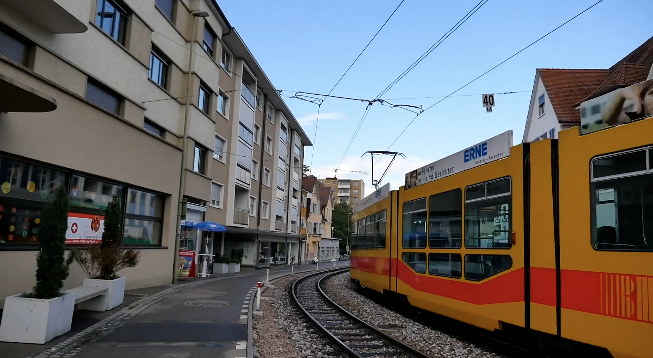

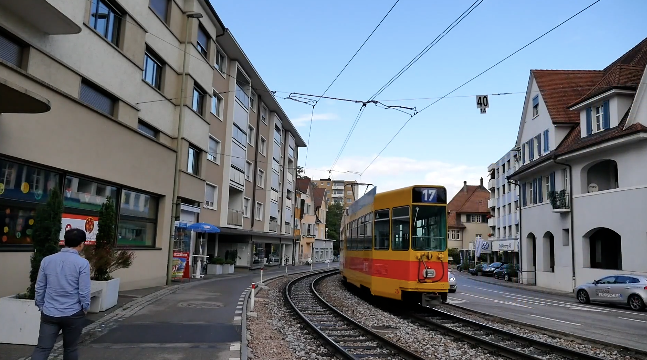

In [8]:
import cv2
import numpy as np
import random2
import likelihood as li

In [9]:
cap = cv2.VideoCapture("data/movie/Tram.mp4")  # 1
ret, frame = cap.read()  # 2
h, w = frame.shape[:2]  # 3
np.random.seed(100)  # 4
Np = 500  # 5
px = np.zeros((Np), dtype=np.int64)  # 6
py = np.zeros((Np), dtype=np.int64)  # 6
lp = np.zeros((Np))  # 7
for i in range(Np):  # 8
    px[i] = int(np.random.uniform(0, w))  # 9
    py[i] = int(np.random.uniform(0, h))  # 9

# trame (電車)の黄色をトラッキングしたいのでその設定
obj = [0, 110, 160]  # 10
while True:
    ret, frame = cap.read()  # 11
    if ret == False:
        break
    lp = li.likelihood(frame, px, py, obj, Np, sigma2=0.001)  # 12
    pxnew = np.array(random2.choices(population=px, weights=lp, k =Np)) + np.random.randint(-15,15,Np)  # 13
    pynew = np.array(random2.choices(population=py, weights=lp, k =Np)) + np.random.randint(-15,15,Np)  # 13
    px = np.where(pxnew > w - 1, w -1, pxnew)  # 14
    py = np.where(pynew > h - 1, h -1, pynew)  # 14
    px = np.where(px < 0, 0, px)  # 15
    py = np.where(py < 0, 0, py)  # 15
    for i in range(Np):  # 16
        cv2.circle(frame, (px[i], py[i]), 1, (0, 255, 0), 1)
    cv2.imshow("img", frame)  # 17
    if cv2.waitKey(10) == 27:
        break
cv2.destroyAllWindows()
cv2.waitKey(1)
cap.release()

### praticle後 video image

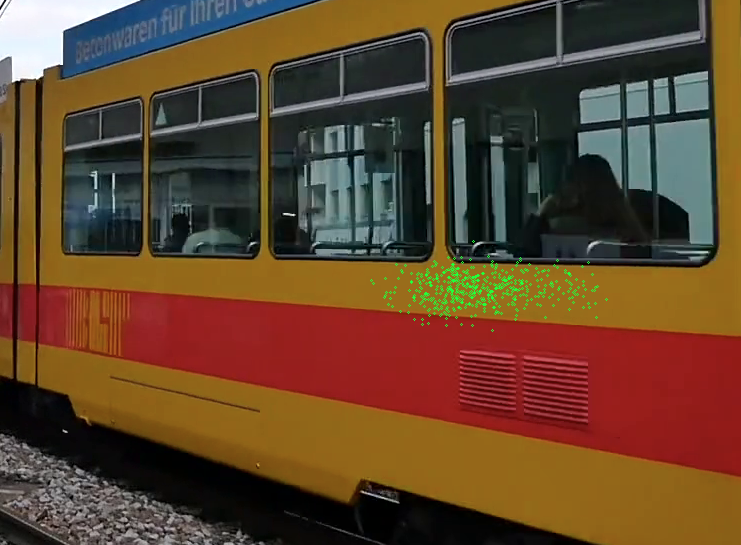

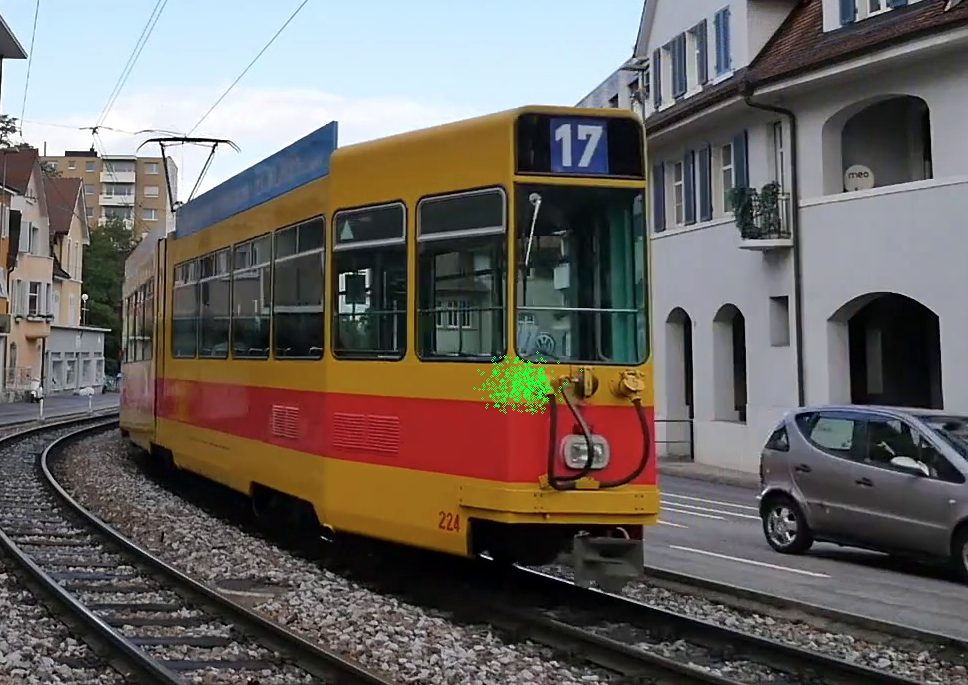

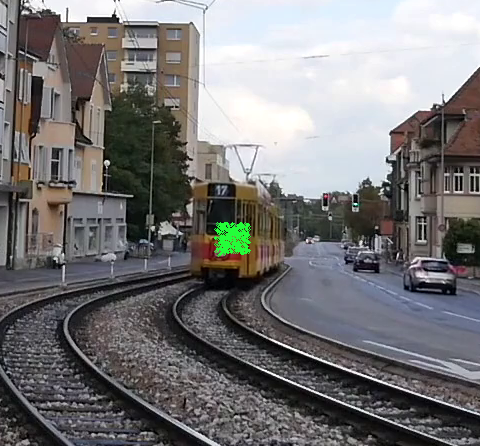

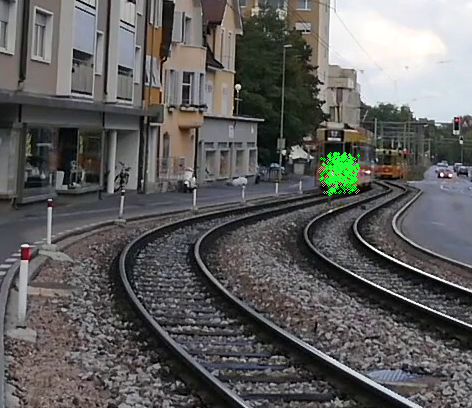

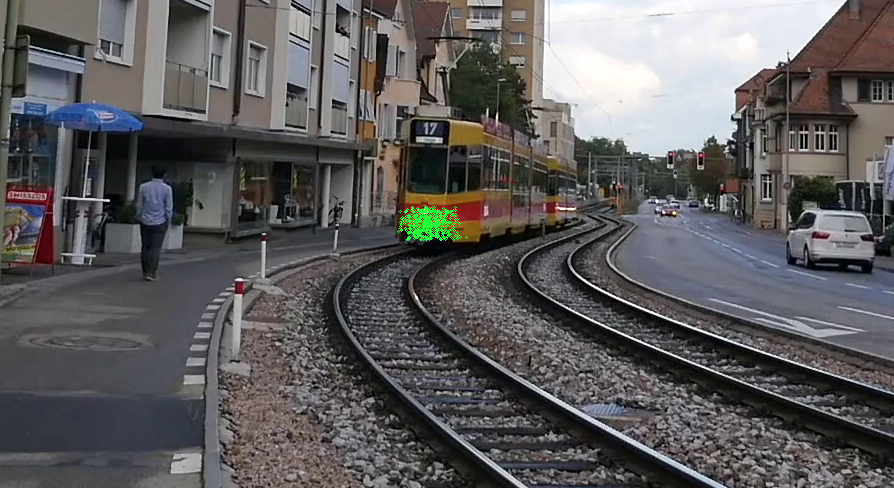

- 電車のオレンジ色にパーティクルが追従している

### <u>praticle filter は目的の物に乱数を使用しながら追随をしていく</u>

### praticle code 解析

1. Video 読み込み

2. 1 frame だけ読み込み

3. h, w に情報を渡す

4. random モジュールを使用する。その種を　１００番に設定しておく

5. Np -> 粒子の個数 = praticle 500個発生させる

6. 粒子の x座標、y座標を作っていく

7. lp -> 粒子の尤度を格納するもの

8. 粒子をばら撒いていく

9. 画面一杯に粒子をばら撒くことができる

10. tram (路面電車)に近い色

11. 1 frame だけ読み込む -> もしも最後のフレームになったら break

12. lp : likelihood(ライクリーフット)を計算して格納する / 画像 : 粒子x,y座標 : 目的のobject=color : 粒子の個数 Np : ガウス関数の sigmaの２乗を入れている


13. 復元抽出をゆるしながら、尤度によって重みづけ、復元抽出を行う。これによってリサンプリングができる。ついでにrandom.randintでランダムウォークも行ってしまう
- <u>１３がリサンプリングと粒子の状態更新</u>

14. px,pynew が画面から飛び出しそうであれば画面の端にして、そうでなければ px,pynew を返す
    - なぜこの様なことをするのか？
    - ランダムウォークするので時々画面から飛び出すことがあるので、画面から飛び出した時の処理を記述しておく必要がある

15. 今度は負の方向に飛び出す恐れがあるのでそちらも記述する

16. 画像の中に粒子を描いていく段階に入る, cv2.circle を使用して描いていく

17. frame 表示

18. esc で break
- あとは default の記述
- 全てのウィンドウを閉じて、メモリの解放